Indicação clínica com:

- rastreio de neoplasias, nódulo em mama -> aprovado
- 1 xícara de trigo e 2 ovos -> negado
- febre e dor no pé -> negado

### Imports

In [ ]:
!pip install flashtext

In [ ]:
!pip install unidecode

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from collections import Counter

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from unidecode import unidecode # tratar os caracteres especiais
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
import matplotlib.pyplot as plt
from typing import Dict
import gensim.parsing.preprocessing as pp
from unidecode import unidecode
import re
import spacy.cli

# modelo medium do spacy
spacy.cli.download("pt_core_news_md")
nlp = spacy.load("pt_core_news_md")

#stopwords em portugues
nltk.download('stopwords')


✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/dados_codigo_40808041.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24539 entries, 0 to 24538
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   medical_request_id      24539 non-null  object
 1   medical_procedure_code  24539 non-null  int64 
 2   age                     24539 non-null  int64 
 3   gender                  24539 non-null  object
 4   clinical_diagnosis      24539 non-null  object
dtypes: int64(2), object(3)
memory usage: 958.7+ KB


### Pré-processamento

In [ ]:
keyword_processor = KeywordProcessor()

def apply_dictionary(text: str):
    """
    Replaces stopwords and applies the dictionary for each text in the corpus.

    Parameters:
    ---------------
    text: string
        Text to be processed.

    Returns:
    Anonymous text: string
        Input text after having it's stop words stripped.
    """

    return keyword_processor.replace_keywords(text)

def fill_text(text: str):
    """
    Fills text field with at least one "empty" char

    Processes text to ensure absence of None and empty text. This is
    accomplished by filling all fields with the aforementioned issues with
    an empty character (" ").

    Parameters:
    ---------------
    text: string
        Text to be processed.

    Returns:
    ---------------
    text: string
        Input text after processing.
    """
    if text is None or len(text) <= 1:
        return " "

    return text


def remove_invalid_numbers(text: str):
    """
    Removes numbers with 11 or more digits from the text. It removes:
    - Numbers with 11+ digits, even if part of a larger string.

    It does NOT remove:
    - Numbers with 10 or fewer digits.
    - Numbers embedded in words (e.g., abc12345678901xyz).
    """

    # Regular expression to remove numbers with more than 10 digits
    pattern = r'\b\d{11,}\b'

    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(df):
    kp = KeywordProcessor()
    #lista customizada de stopwords por modelo
    stopwords_modelo = ['de', 'que', 'da', 'o', 'e']
    stopwords_nltk = list(stopwords.words('portuguese'))
    stopwords_modelo.extend(stopwords_nltk)

    for i in stopwords_modelo:
        kp.add_keyword(i, ' ')
    df['modified_text'] = df.clinical_diagnosis.apply(kp.replace_keywords)
    return df

# Função para lematizar um texto
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

#Função para replace de dicionário específico
def replace_dictionary(df, col):
    kp = KeywordProcessor()
    dicionario_modelo = {
        'ca' : 'cancer',
        'pcte': 'paciente'
    }

    for i in dicionario_modelo.items():
        # print(i[0], i[1])

        kp.add_keyword(i[0], i[1])
    df[col] = df[col].apply(kp.replace_keywords)
    return df

def preprocess(
    df: pd.DataFrame,
    # keywords: Dict[str, str],
    column: str = "modified_text",
):
    """
    NLP Preprocessing Pipeline

    Implements the sequence of steps taken in preparing text for training.

    Parameters:
    ---------------
    df: pandas.DataFrame
        Data to be preprocessed.

    keywords: Dictinary of strings
        Keywords used in text prepping.

    column: string
        Name of the column target to pre-processing.

    Returns:
    ---------------
    """

    # for keyword in keywords.items():
    #     keyword_processor.add_keyword(*keyword)

    pipeline = [
        pp.lower_to_unicode,
        unidecode,
        pp.strip_non_alphanum,
        pp.strip_tags,
        pp.strip_punctuation,
        # apply_dictionary,
        remove_invalid_numbers,
        pp.strip_multiple_whitespaces,
        str.strip,
        fill_text,
    ]

    def do_preprocessing(text: str):
        for filter in pipeline:
            text = filter(text)

        return text

    df['modified_text'] = df[column].map(do_preprocessing)
    return df

def term_penalty(text, bow, weight):
  out_word = 0

  for word in text.split():
    if word not in bow:
      out_word += 1

  return out_word * weight

In [ ]:
replace_dictionary(df, 'clinical_diagnosis')
remove_stopwords(df)
preprocess(df, column='modified_text')

# Aplicar
df['texto_lematizado'] = df['modified_text'].apply(lemmatize_text)


'paciente climaterio vir rotina ginecologico anual paciente climaterio vir rotina ginecologico anual codigo Cid n95 mama denso acompr pedido paciente mama denso acompr pedido paciente nodulo mama direito esquerdo nodulo mama direito esquerdo apresentr emagrecimento importante ultimos mês necessitar investigacao completo codigo cid n63 rotina rotina climaterio densitometria coluna femur dor abdominal leucorreia dor baixo ventre leucorreia adinamir cansacocodigo cid R10 cancer mama seguimenyto cancer mama seguimenytocodigo Cid c50 paciente menopauso comtrole anual mamografia historico cancer mama familia menopauso rastreamento neoplasio menopauso rastreamento neoplasia rotina go Pedidod octe dor bv tipo colica Mams denso invest finfonodo axila acomp massa ossea rotina go Pedidod octe dor bv tipo colica Mams denso invest finfonodo axila acomp massa ossea codigo Cid R10 avaliac ginecologico Mastologicacodigo cid z014 Menopausa protese mamaria nodulo menopauso protese mamaria nodulo pedir e

### Gerando Bag of Words

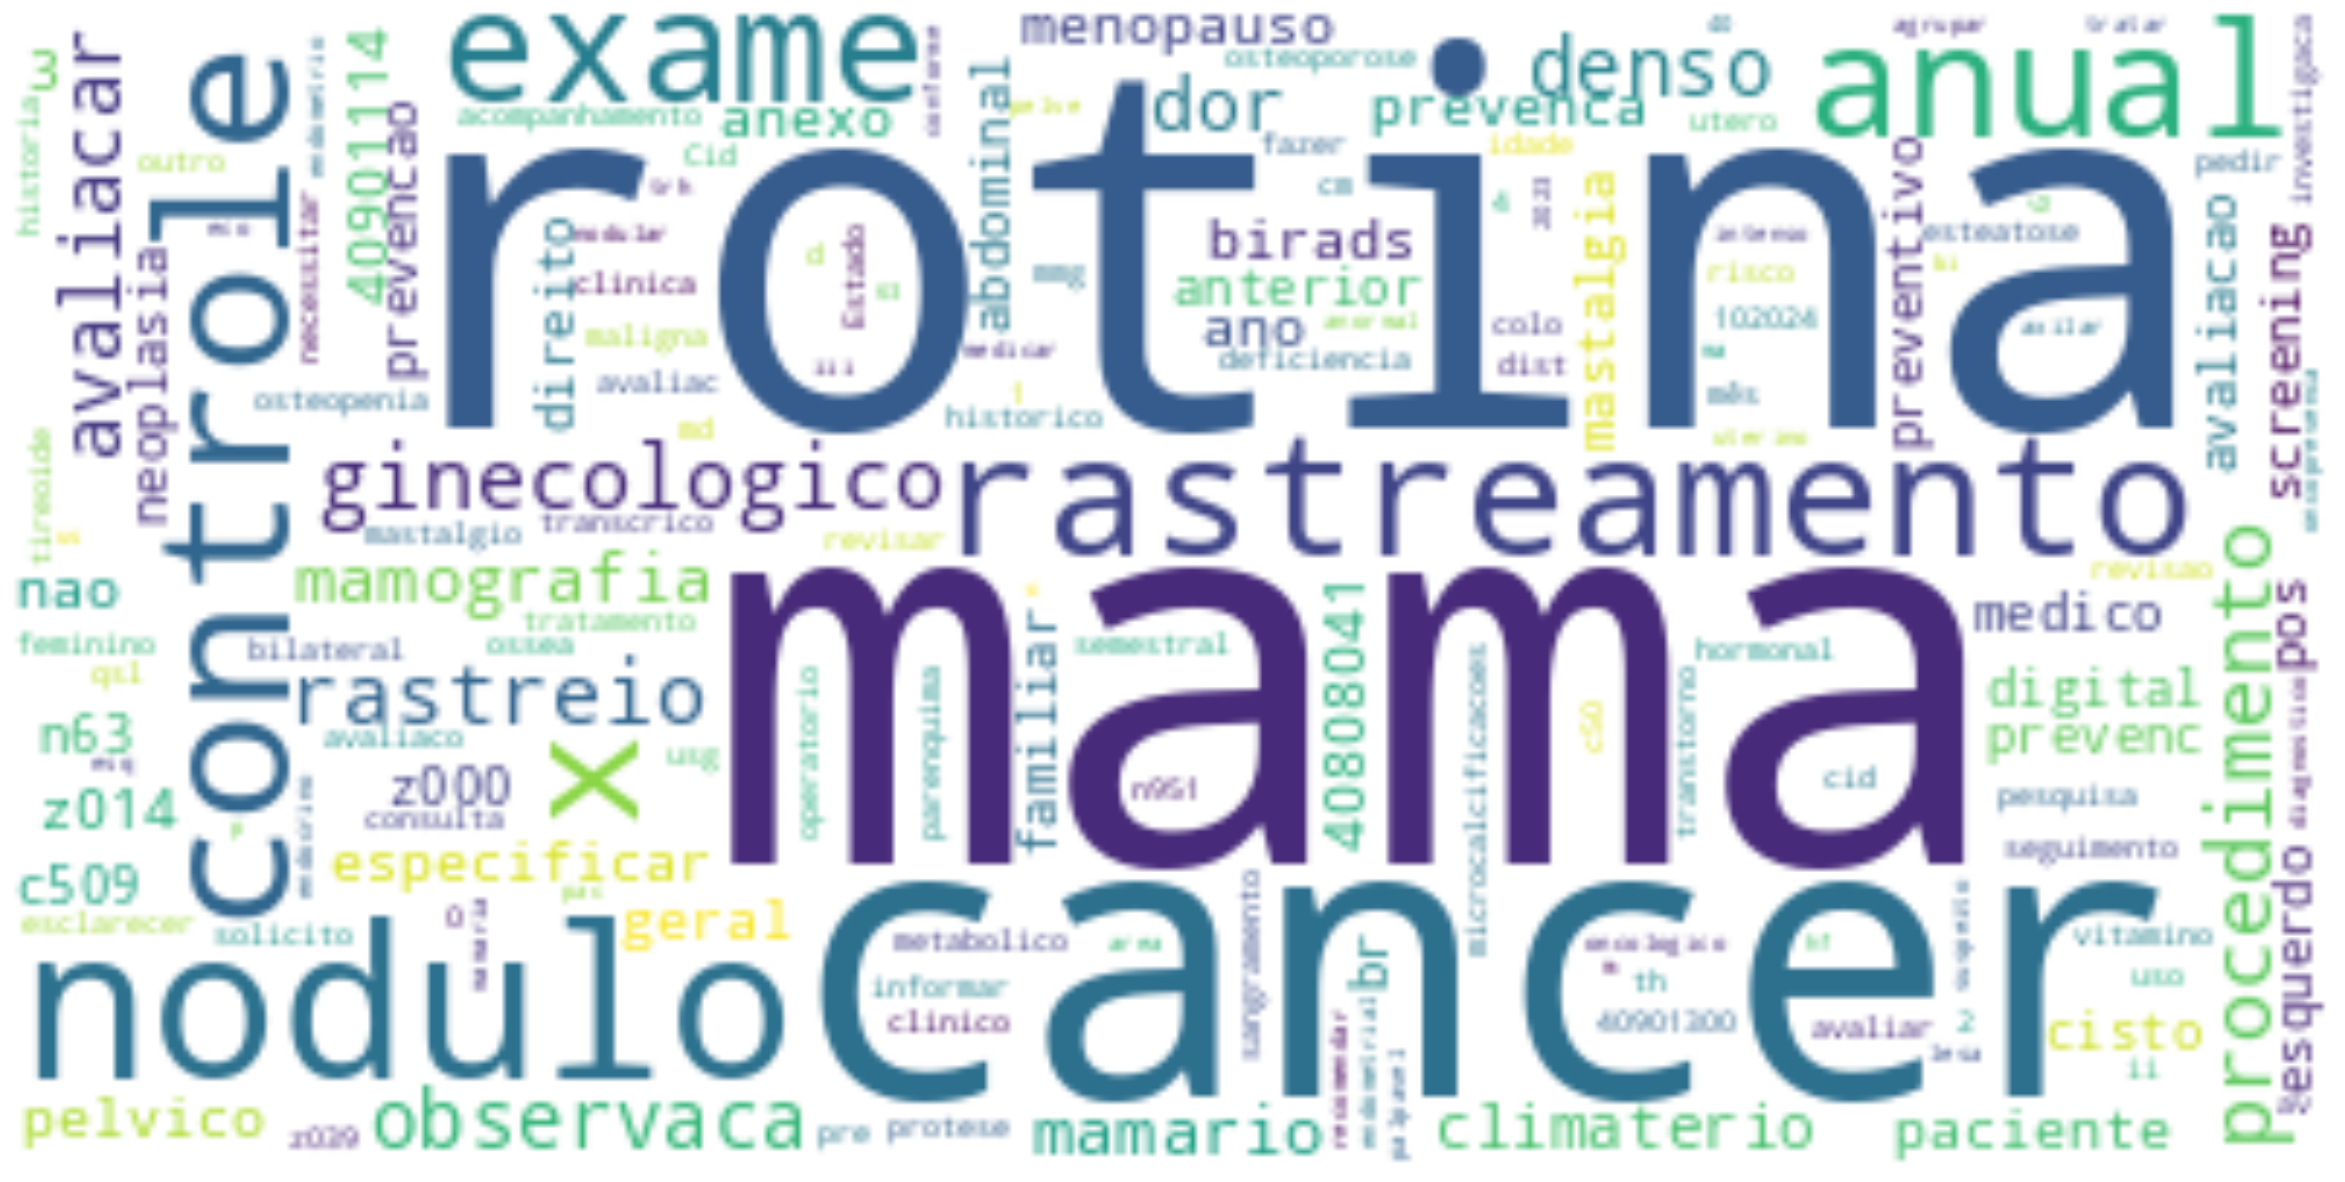

In [ ]:
# Nuvem de palavras (EDA de texto)
texto = df.texto_lematizado.str.cat(sep=' ').split()
bow_wc = Counter(texto)

wordcloud = WordCloud(background_color='white', include_numbers=True).generate_from_frequencies(bow_wc)
plt.figure(figsize=(30,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Vetorização do texto
tfdf = TfidfVectorizer(min_df=0.005)
x = tfdf.fit_transform(df.texto_lematizado)

In [ ]:
# Relevância das palavras a partir da vetorização
termos = tfdf.get_feature_names_out()
df_tfidf = pd.DataFrame(x.toarray(), columns = termos)

In [ ]:
df_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24539 entries, 0 to 24538
Data columns (total 72 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   40808041        24539 non-null  float64
 1   40901114        24539 non-null  float64
 2   abdominal       24539 non-null  float64
 3   acompanhamento  24539 non-null  float64
 4   anexo           24539 non-null  float64
 5   ano             24539 non-null  float64
 6   anterior        24539 non-null  float64
 7   anual           24539 non-null  float64
 8   avaliac         24539 non-null  float64
 9   avaliacao       24539 non-null  float64
 10  avaliacar       24539 non-null  float64
 11  avaliar         24539 non-null  float64
 12  bilateral       24539 non-null  float64
 13  birads          24539 non-null  float64
 14  br              24539 non-null  float64
 15  c509            24539 non-null  float64
 16  cancer          24539 non-null  float64
 17  cid             24539 non-null 

## Testes

In [ ]:
ind_clinica = ['rastreio de neoplasias, nódulo em mama', '1 xícara de trigo e 2 ovos', 'febre e dor no pé', 'febre', 'dor dor', '1 xícara de trigo e 2 ovos e dor']

In [ ]:
df_teste = pd.DataFrame(ind_clinica, columns=['clinical_diagnosis'])

In [ ]:
df_teste

,clinical_diagnosis
0,"rastreio de neoplasias, nódulo em mama"
1,1 xícara de trigo e 2 ovos
2,febre e dor no pé
3,febre
4,dor dor
5,1 xícara de trigo e 2 ovos e dor


In [ ]:
#Preprocess escoragem
replace_dictionary(df_teste, 'clinical_diagnosis')
remove_stopwords(df_teste)
preprocess(df_teste, column='modified_text')
df_teste['texto_lematizado'] = df_teste['modified_text'].apply(lemmatize_text)
df_teste

,clinical_diagnosis,modified_text,texto_lematizado
0,"rastreio de neoplasias, nódulo em mama",rastreio neoplasias nodulo mama,rastreio neoplasia nodulo mama
1,1 xícara de trigo e 2 ovos,1 xicara trigo 2 ovos,1 xicara trigo 2 ovo
2,febre e dor no pé,febre dor pe,febre dor pe
3,febre,febre,febre
4,dor dor,dor dor,dor dor
5,1 xícara de trigo e 2 ovos e dor,1 xicara trigo 2 ovos dor,1 xicara trigo 2 ovo dor


In [ ]:
resultado = tfdf.transform(df_teste.texto_lematizado)
df_result = pd.DataFrame(resultado.toarray(), columns = termos)
df_result

,40808041,40901114,abdominal,acompanhamento,anexo,ano,anterior,anual,avaliac,avaliacao,...,rastreamento,rastreio,rotina,screening,seguimento,semestral,th,uso,z000,z014
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.487621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_teste['score_sum'] = df_result.sum(axis=1)

In [ ]:
# Se não tiver dentro dessa lista toma uma penalidade
bow = tfdf.get_feature_names_out().tolist()
bow


['40808041',
 '40901114',
 'abdominal',
 'acompanhamento',
 'anexo',
 'ano',
 'anterior',
 'anual',
 'avaliac',
 'avaliacao',
 'avaliacar',
 'avaliar',
 'bilateral',
 'birads',
 'br',
 'c509',
 'cancer',
 'cid',
 'cisto',
 'climaterio',
 'controle',
 'denso',
 'digital',
 'direito',
 'dor',
 'esclarecer',
 'especificar',
 'esquerdo',
 'estado',
 'exame',
 'familiar',
 'feminino',
 'geral',
 'ginecologico',
 'hormonal',
 'ii',
 'informar',
 'mama',
 'mamario',
 'mamografia',
 'mastalgia',
 'mastalgio',
 'medico',
 'menopauso',
 'n63',
 'n951',
 'nao',
 'neoplasia',
 'nodulo',
 'observaca',
 'osteopenia',
 'paciente',
 'pedir',
 'pelvico',
 'pesquisa',
 'pos',
 'pre',
 'prevenc',
 'prevenca',
 'prevencao',
 'preventivo',
 'procedimento',
 'rastreamento',
 'rastreio',
 'rotina',
 'screening',
 'seguimento',
 'semestral',
 'th',
 'uso',
 'z000',
 'z014']

In [ ]:
#Calcula os penalties
df_teste['penalty'] = df_teste['texto_lematizado'].apply(lambda x: term_penalty(x, bow, -0.5))
#Calcula score final
df_teste['score_final'] = df_teste['score_sum'] + df_teste['penalty']
df_teste

,clinical_diagnosis,modified_text,texto_lematizado,score_sum,penalty,score_final
0,"rastreio de neoplasias, nódulo em mama",rastreio neoplasias nodulo mama,rastreio neoplasia nodulo mama,1.933538,-0.0,1.933538
1,1 xícara de trigo e 2 ovos,1 xicara trigo 2 ovos,1 xicara trigo 2 ovo,0.000000,-2.5,-2.500000
2,febre e dor no pé,febre dor pe,febre dor pe,1.000000,-1.0,0.000000
3,febre,febre,febre,0.000000,-0.5,-0.500000
4,dor dor,dor dor,dor dor,1.000000,-0.0,1.000000
5,1 xícara de trigo e 2 ovos e dor,1 xicara trigo 2 ovos dor,1 xicara trigo 2 ovo dor,1.000000,-2.5,-1.500000
